In [1]:
import stockinator as st
import yfinance as yf
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt
import requests
import datetime
import time
import os
import sys
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)

In [64]:
all_data = pd.read_pickle('stocks/nasdaq_1d.pkl')
stocklist = st.unique_list([x[0] for x in all_data.columns.values])
total_stocks = len(stocklist)

In [69]:
exportList = pd.DataFrame(columns=[
    'Stock', 'RSI', 'Price', 
    '90 Avg Volume', '10 Avg Volume', 
    'EMA_1', 'EMA_2', 'EMA_3', 
    '52 Week Low', '52 Week High', 'Pct of 52 High'])

offset = 0
n = -1
for stock in stocklist:
    n += 1
    #print("Index {} of {} Stock [{}] \r".format(n, total_stocks, stock))
    sys.stdout.write("Index {} of {} Stock [{}] \r".format(n, total_stocks-1, stock))
    sys.stdout.flush()

    df = all_data[stock]
    if offset > 0:
        df = df[:-offset]

    df = df.dropna(how='all')
    if df.empty:
        continue

    df = st.calculate_rsi(df)
    df = st.calculate_ema(df, periods=[50, 125, 200])
    df = st.calculate_volume(df)
    df = st.calculate_mfi(df)

    try:
        moving_average_long_21 = df["EMA_3"][-21]
    except Exception:
        moving_average_long_21 = 0

    try:
        currentClose = df["Adj Close"][-1]
        low_of_52week = min(df["Adj Close"][-260:])
        high_of_52week = max(df["Adj Close"][-260:])
        moving_average_short = df["EMA_1"][-1]
        moving_average_medium = df["EMA_2"][-1]
        moving_average_long = df["EMA_3"][-1]
        avg_volume_90 = df['90 Avg Volume'][-1]
        avg_volume_10 = df['10 Avg Volume'][-1]
        rsi = df['RSI'][-1]
    except Exception:
        continue

    try:
        assert(currentClose > 5)
        assert(avg_volume_90 > 250000)
        #assert(moving_average_50 > moving_average_200)
        #assert(moving_average_200 > moving_average_200_21)
        assert(currentClose > moving_average_short > moving_average_medium > moving_average_long)
        assert(currentClose >= (1.3 * low_of_52week))
        #assert(currentClose >= (1.1 * low_of_52week))
        assert(currentClose >= (.75 * high_of_52week))
        #assert(currentClose <= (.5 * high_of_52week))
        #assert(rsi > 40)
        #assert(rsi < 60)
        assert(avg_volume_10 > avg_volume_90)
    except AssertionError:
        continue
    except IndexError as e:
        continue
    except Exception as e:
        print(e)

    try:
        exportList = exportList.append(
            {
                'Stock': stock, 
                'RSI': rsi, 
                'Price': currentClose,
                '90 Avg Volume': avg_volume_90,
                '10 Avg Volume': avg_volume_10,
                'EMA_1': moving_average_short, 
                'EMA_2': moving_average_medium, 
                'EMA_3': moving_average_long, 
                '52 Week Low': low_of_52week, 
                '52 Week High': high_of_52week,
                'Pct of 52 High': (currentClose / high_of_52week) * 100
            }, ignore_index=True)
    except Exception as e:
        print(e)

In [70]:
print(exportList.sort_values('Pct of 52 High', ascending=True))
exportList.sort_values('Pct of 52 High', ascending=False).to_csv('stocks.csv', index=False)

    Stock        RSI       Price  90 Avg Volume  10 Avg Volume       EMA_1       EMA_2       EMA_3  52 Week Low  52 Week High  Pct of 52 High
70   LUNA  49.053005    7.040000      277787.78       298720.0    6.992134    6.868942    6.528929     3.970000      9.230000       76.273026
57   PSTI  57.356199    9.570000     1534233.33      2429560.0    6.989216    5.516051    5.457024     2.890000     12.430000       76.991146
91   CEMI  54.597686   12.030000      818780.00      1602200.0    9.250045    7.004108    6.510081     2.360000     15.540000       77.413126
71   AVDL  49.538488    9.300000      872402.22      1549750.0    8.906949    7.599968    6.648304     1.150000     11.750000       79.148938
51   DCPH  59.385628   55.500000      608461.11       708200.0   49.977123   49.179859   46.237470    19.950001     69.930000       79.365079
18   INSG  52.778624   11.190000     3885642.22      6302350.0    9.683975    8.072385    7.229199     3.620000     14.070000       79.530916
54    

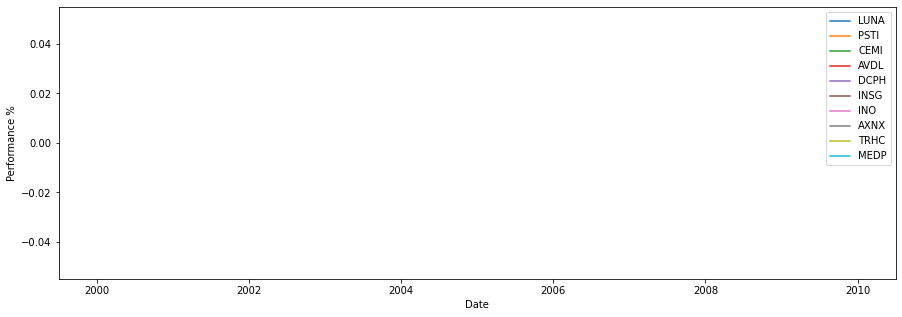

In [71]:
top10 = exportList.sort_values('Pct of 52 High', ascending=True)[0:10]
plt.figure(figsize=(15,5))
plt.xlabel("Date")
plt.ylabel("Performance %")
for s in top10.Stock.values:
    perf = all_data[s][-offset:-offset+89]
    change = (perf.Close - perf.iloc[0]['Close']) / perf.iloc[0].Close
    plt.plot(perf.index, change*100, label=s)
plt.legend()
plt.show()

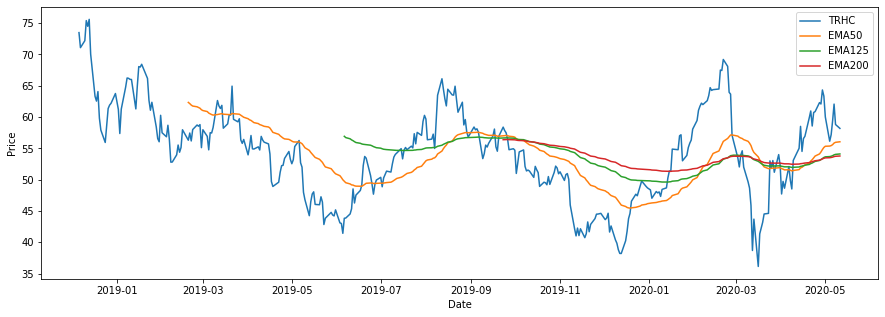

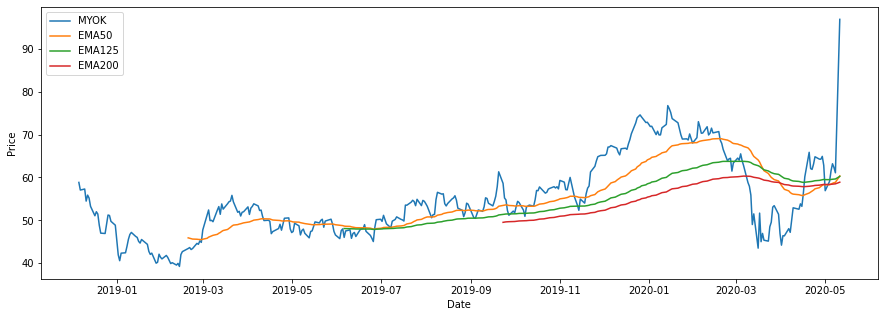

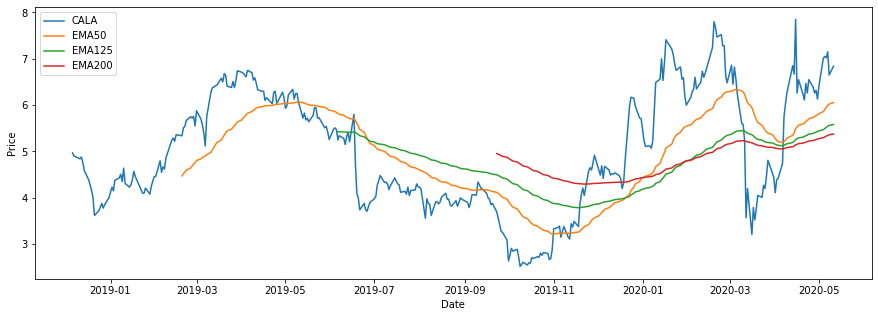

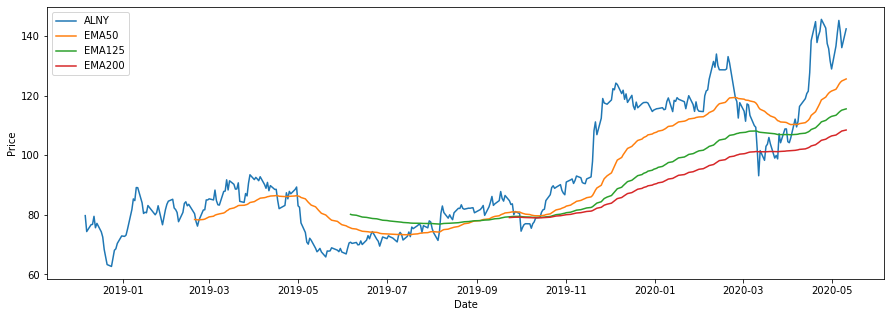

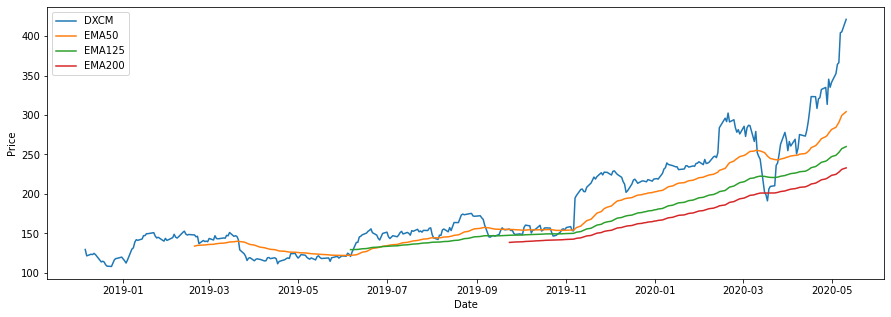

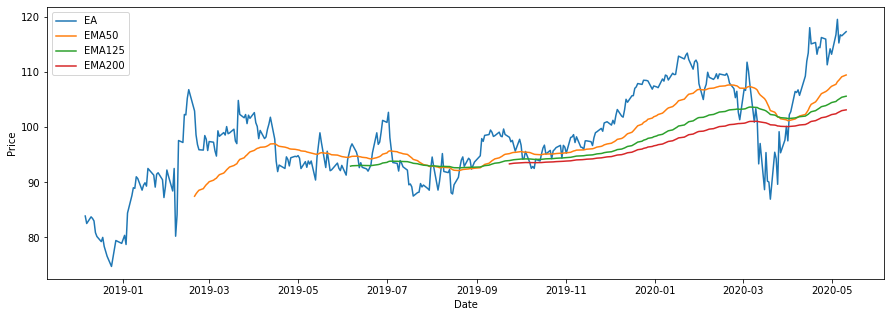

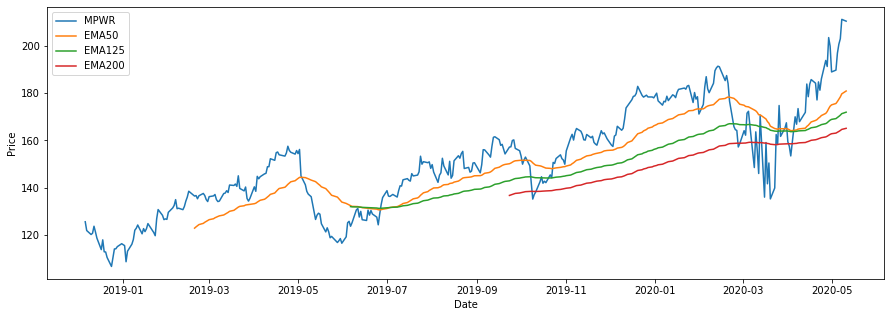

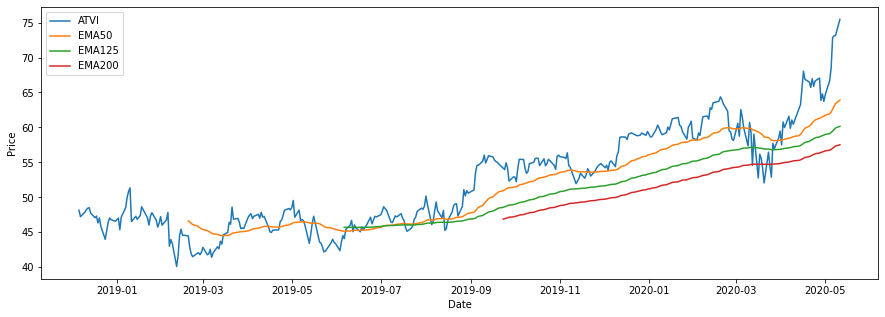

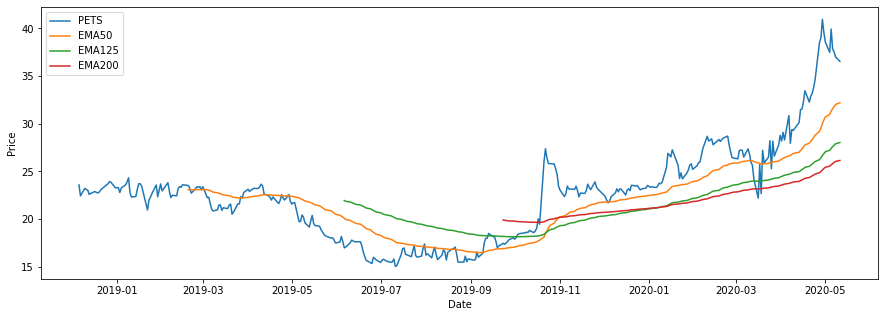

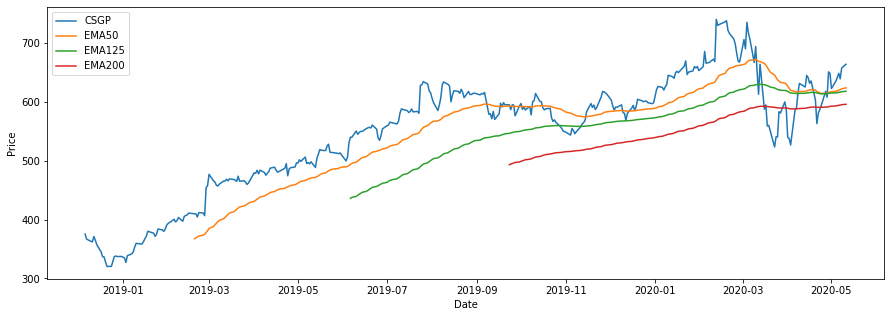

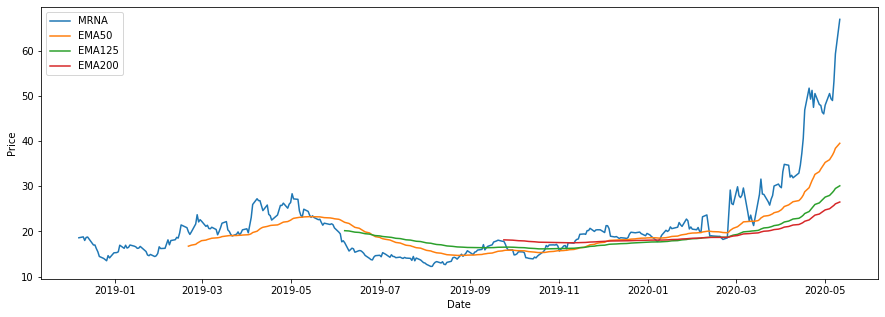

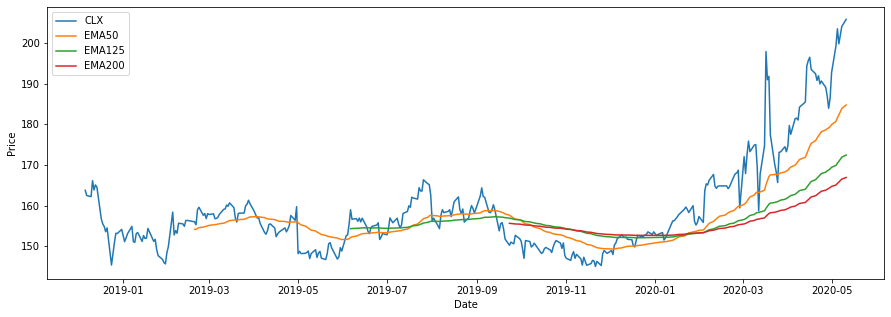

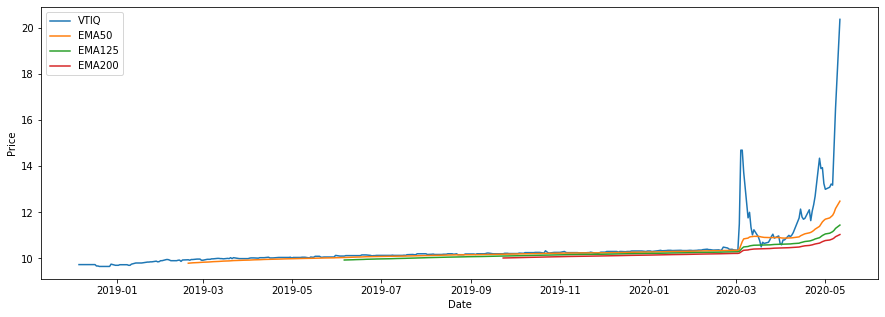

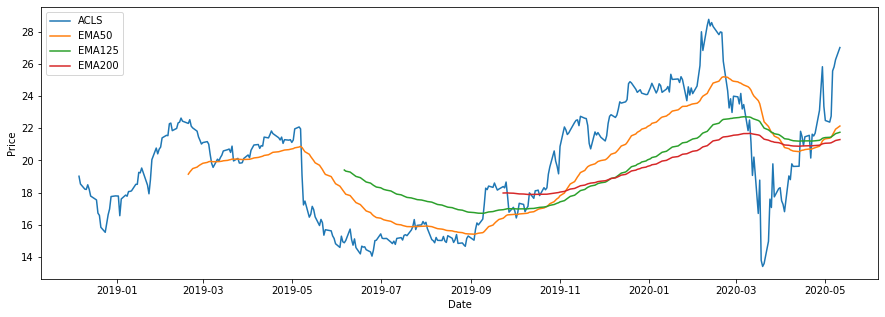

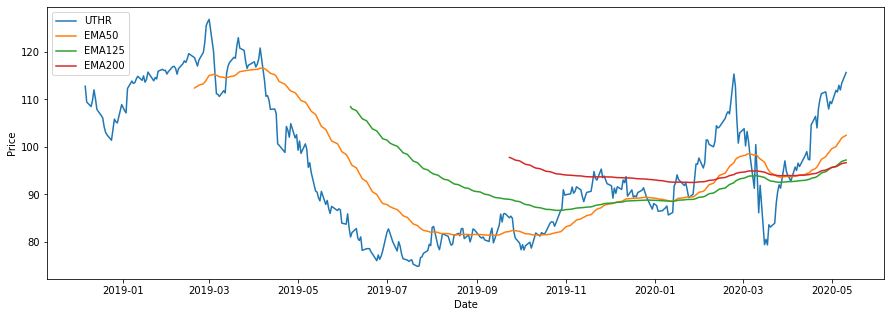

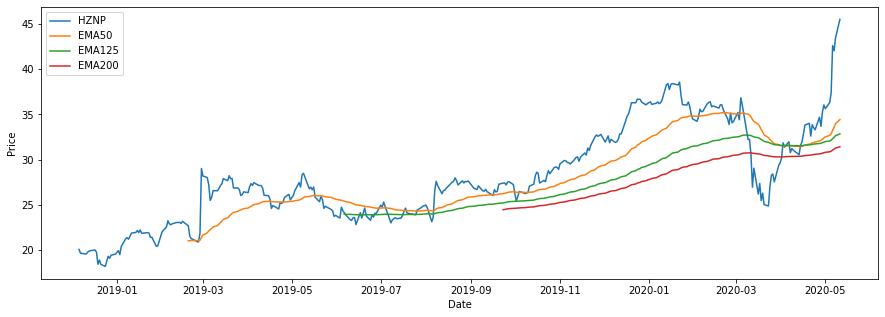

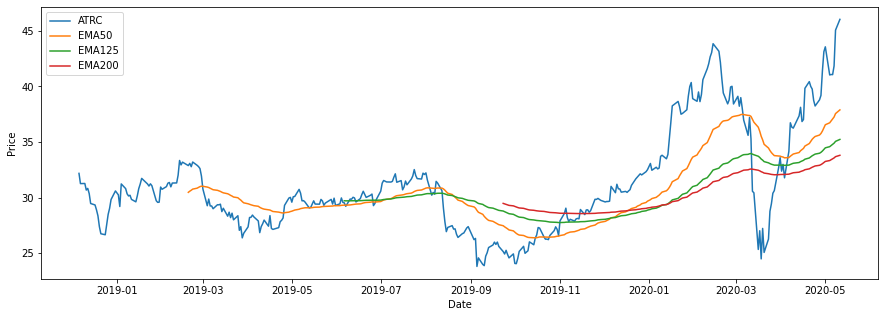

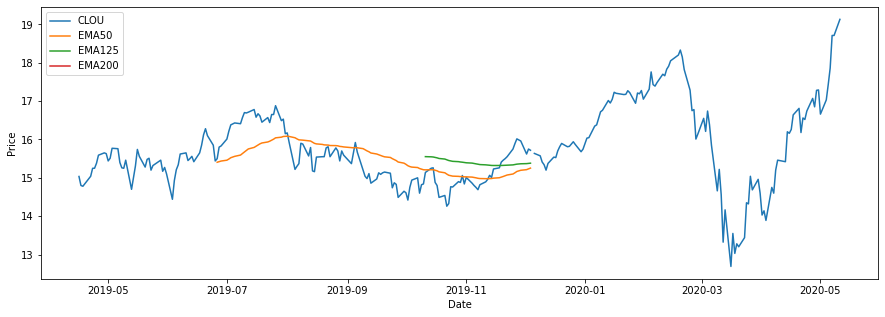

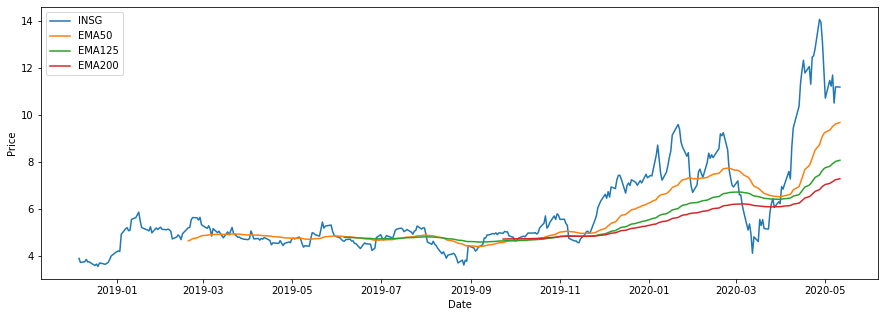

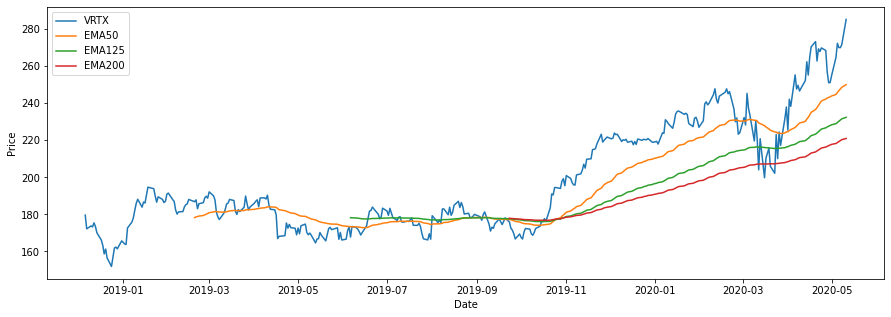

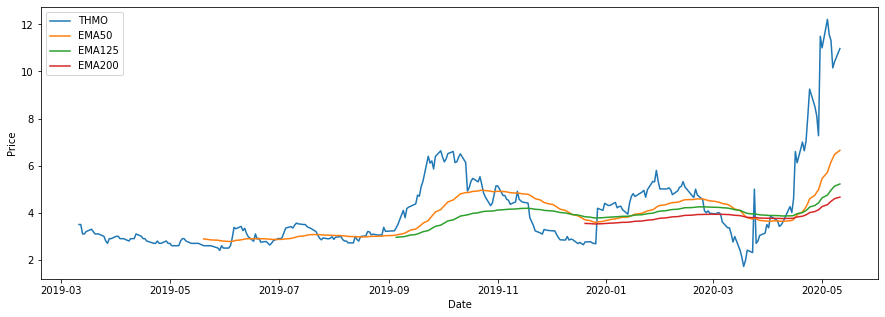

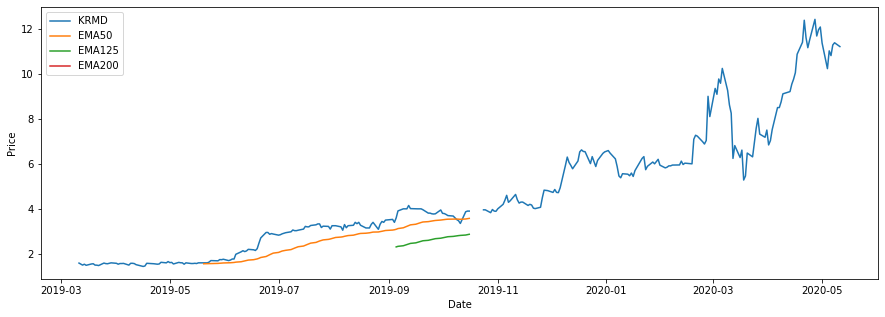

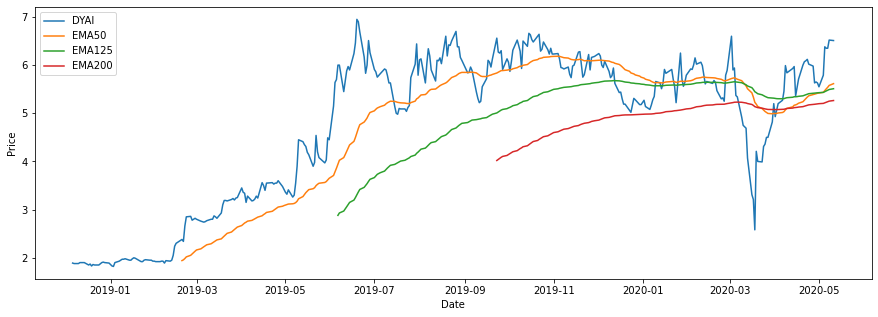

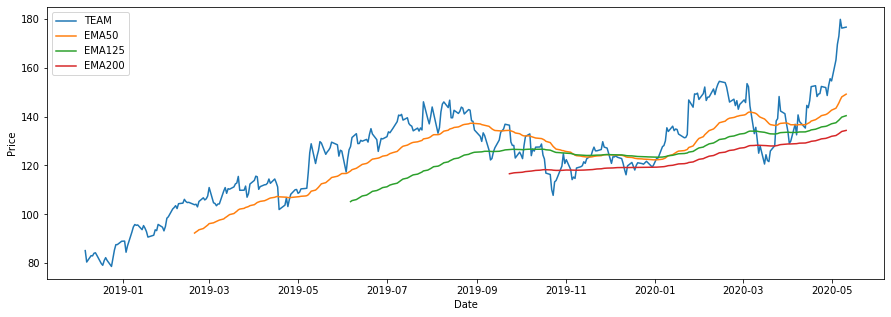

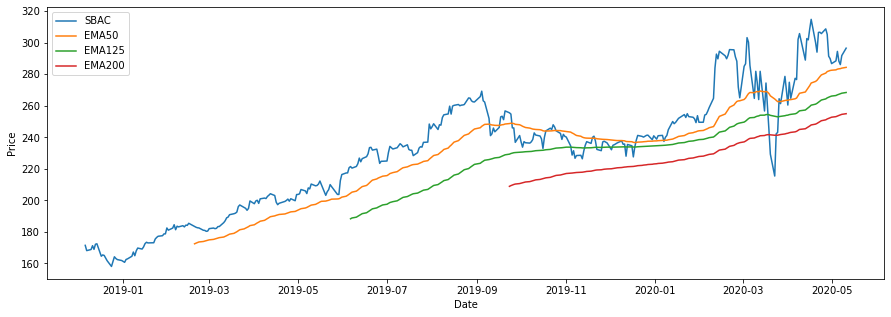

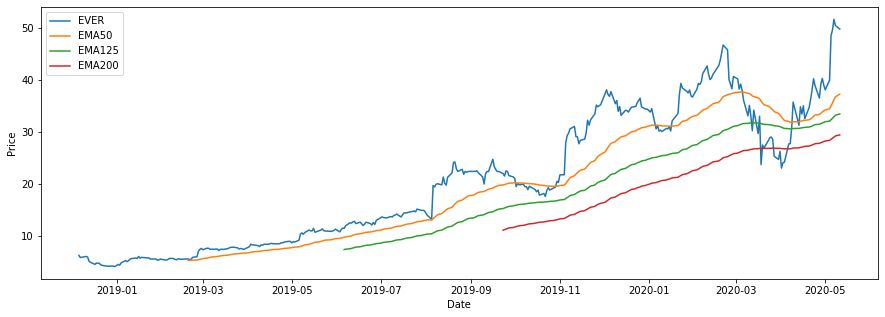

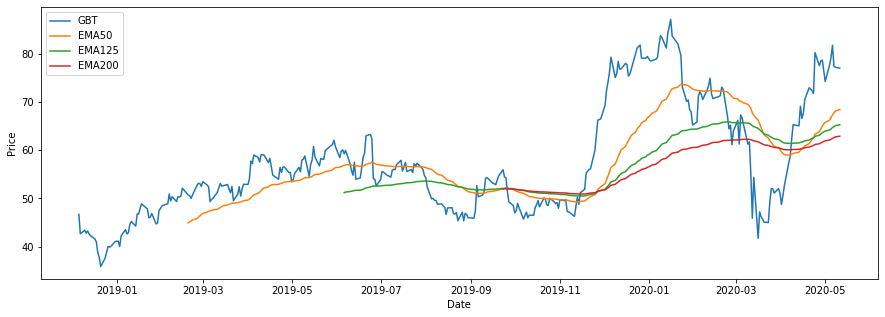

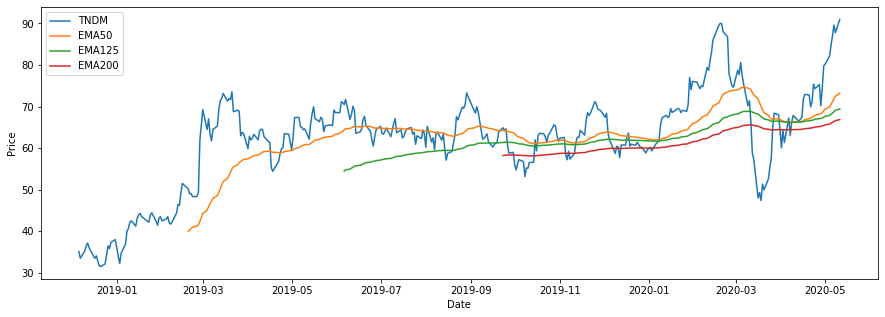

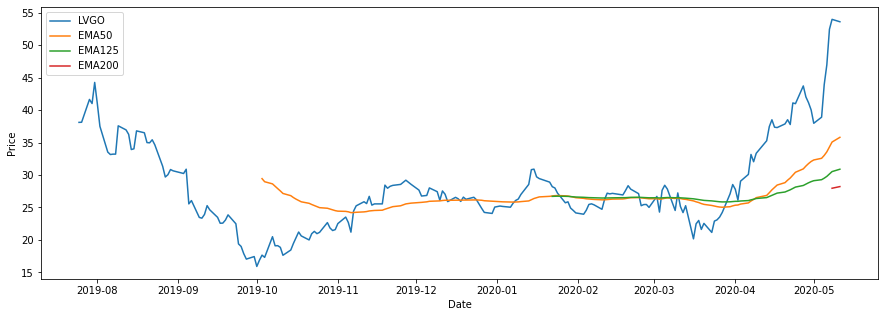

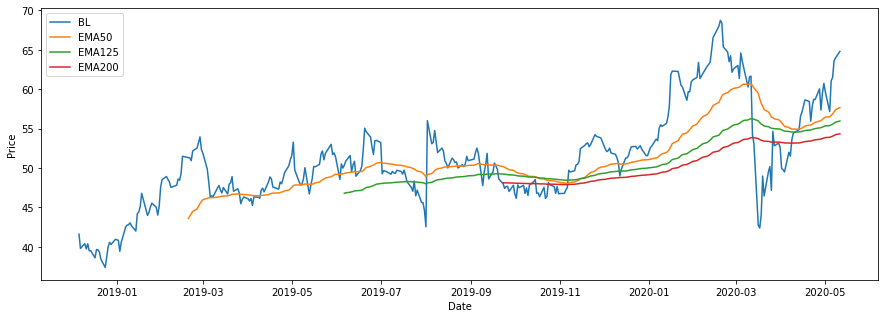

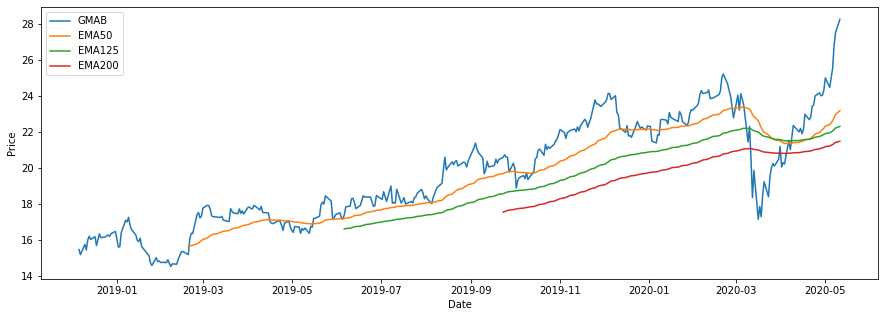

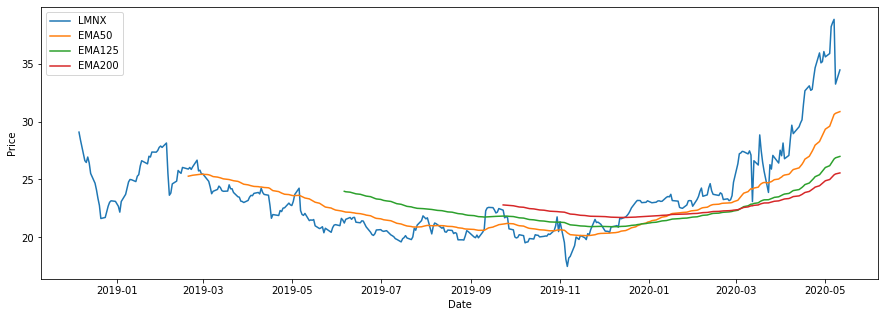

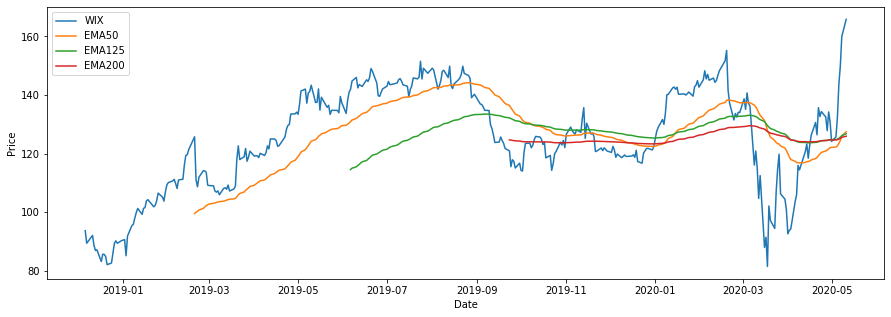

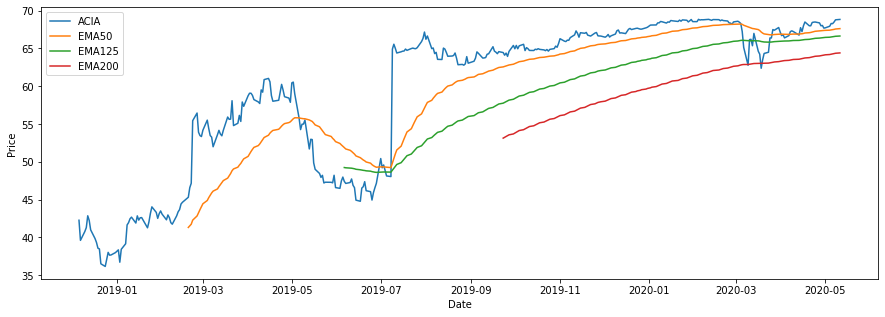

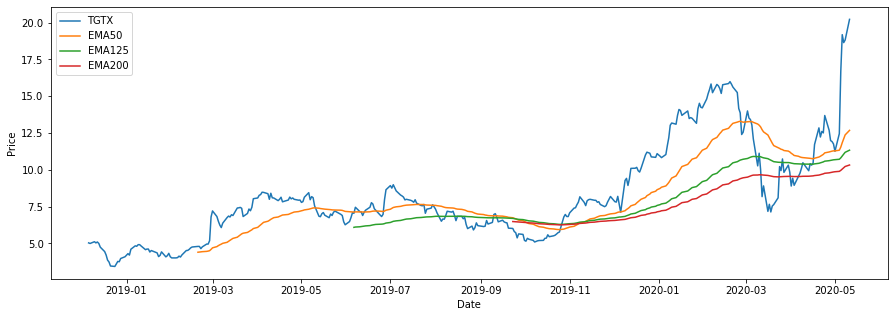

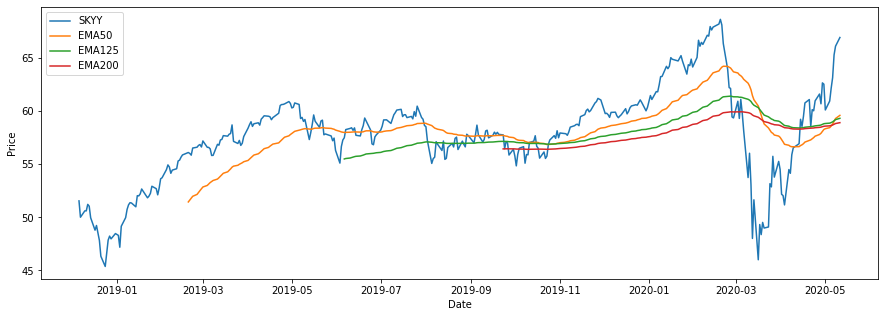

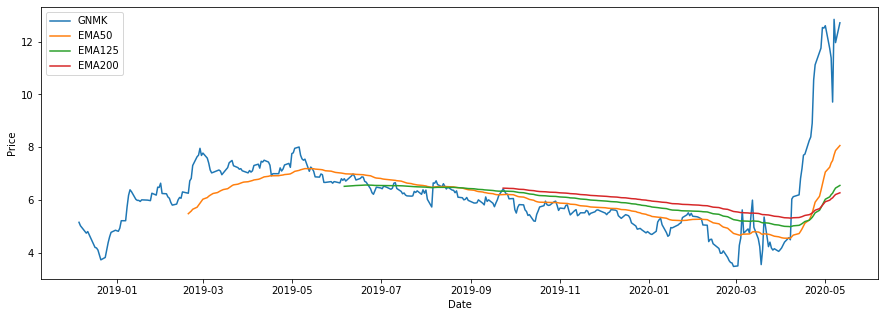

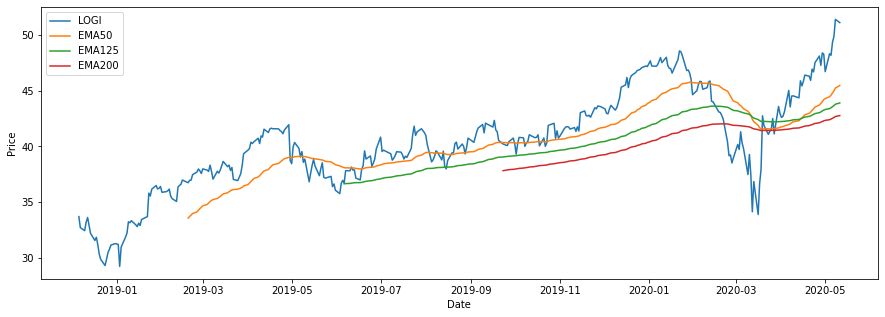

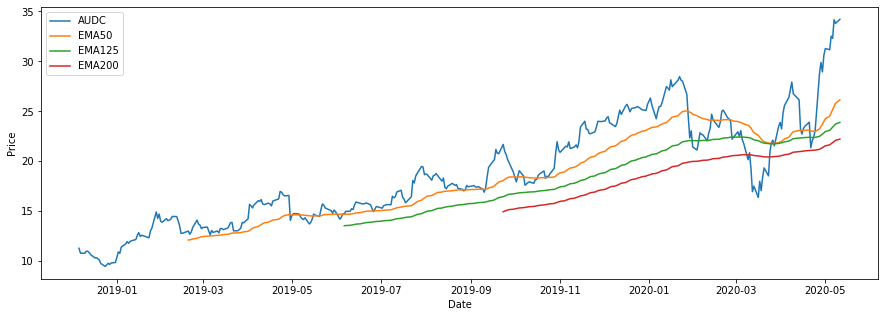

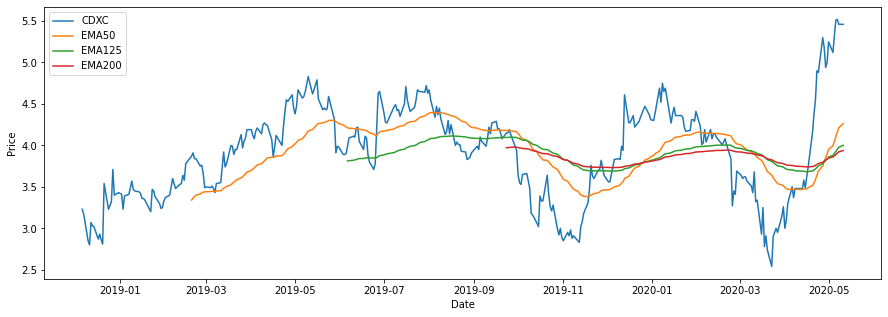

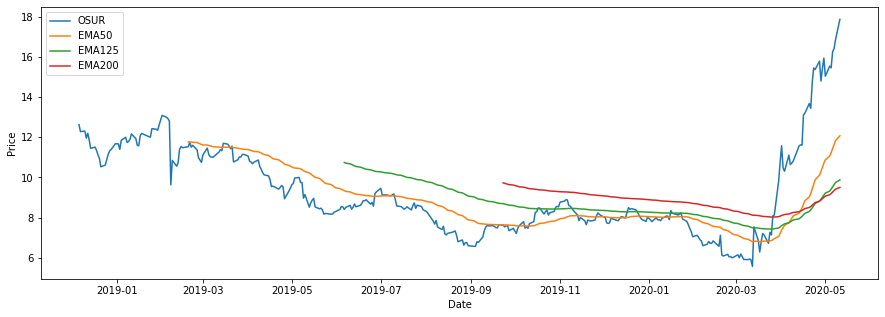

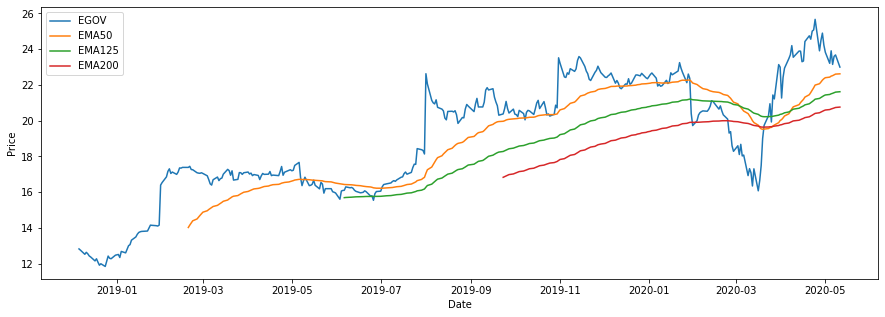

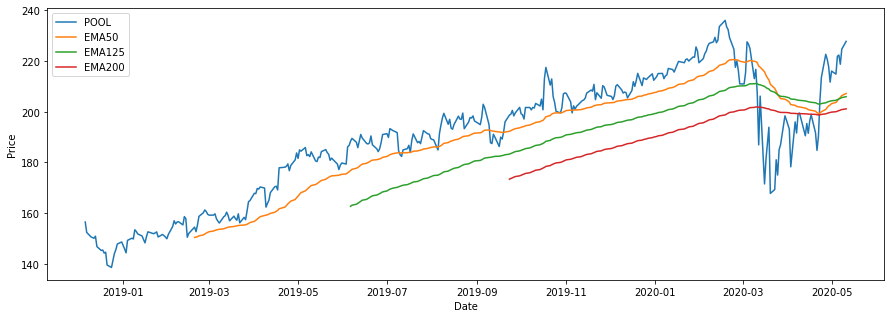

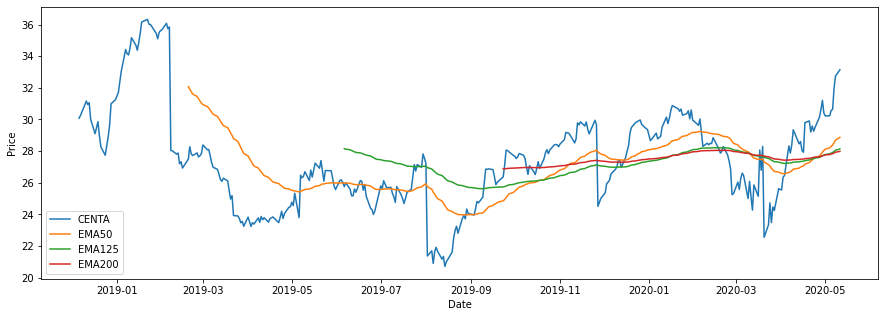

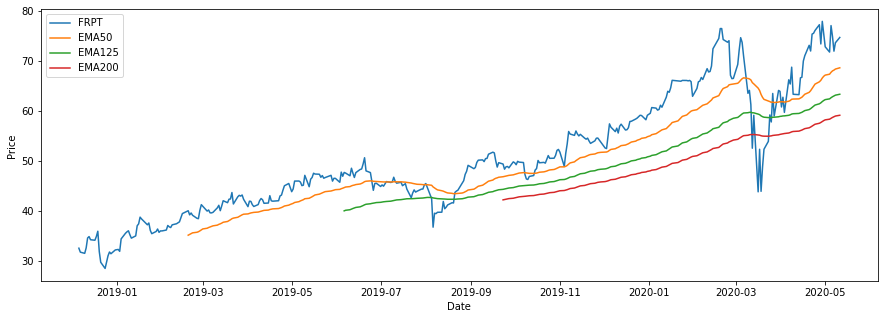

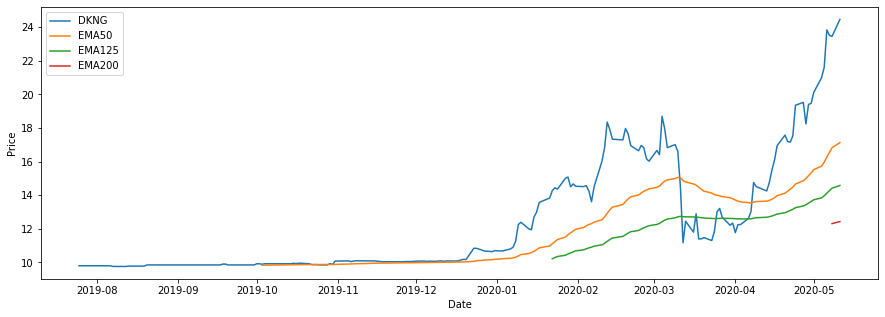

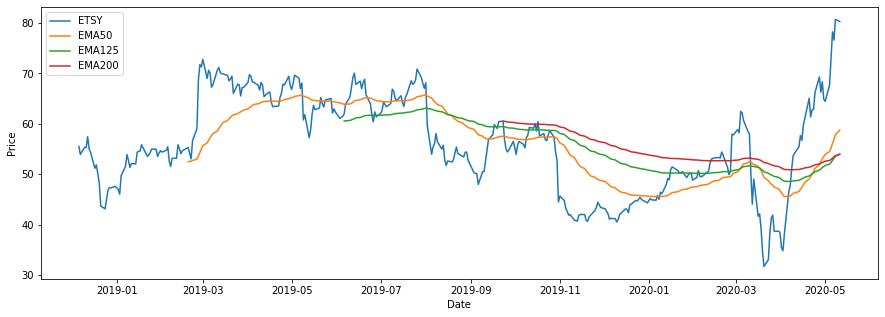

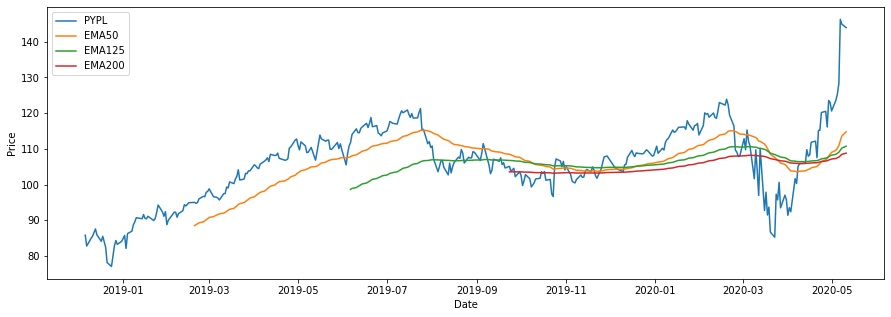

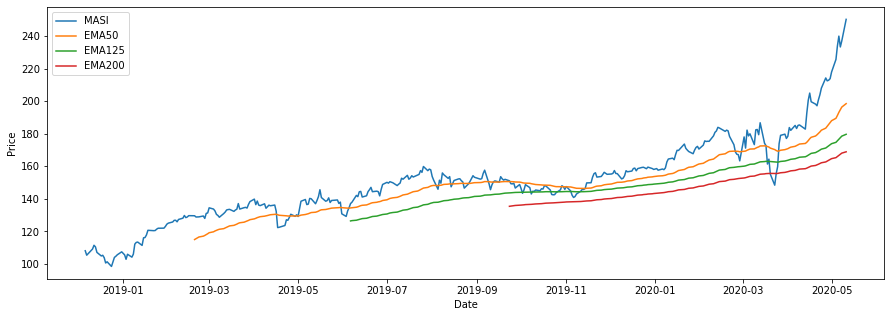

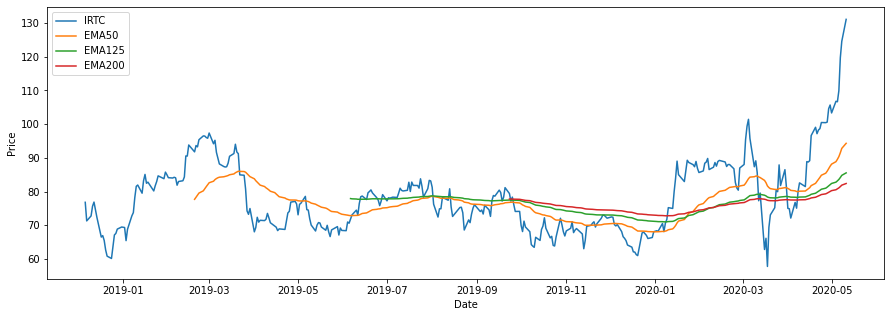

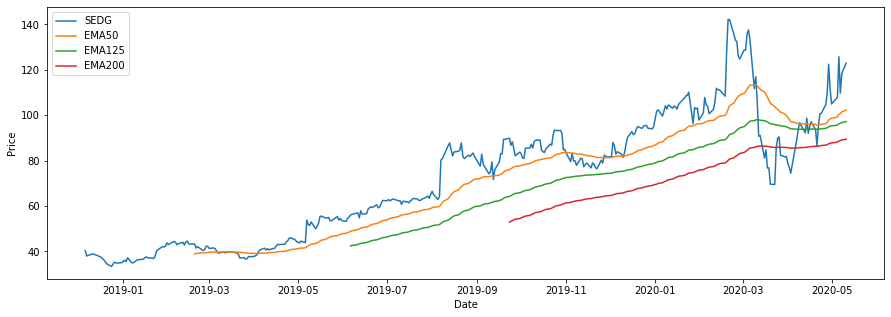

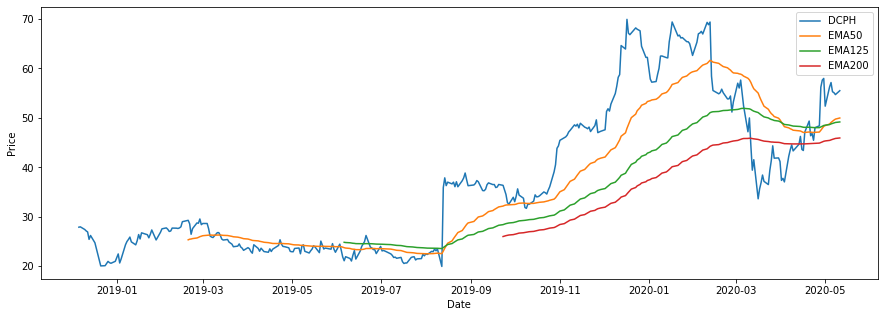

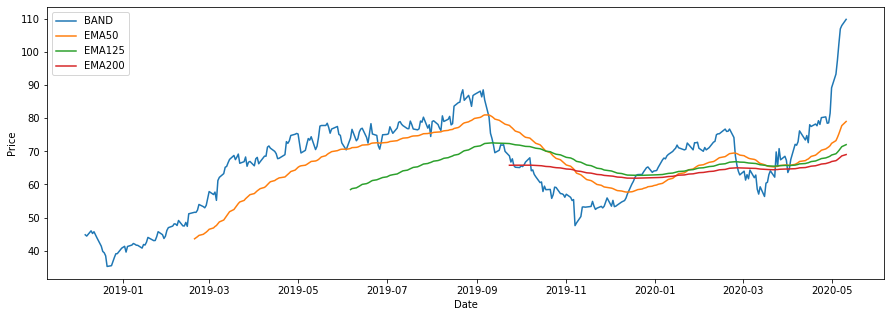

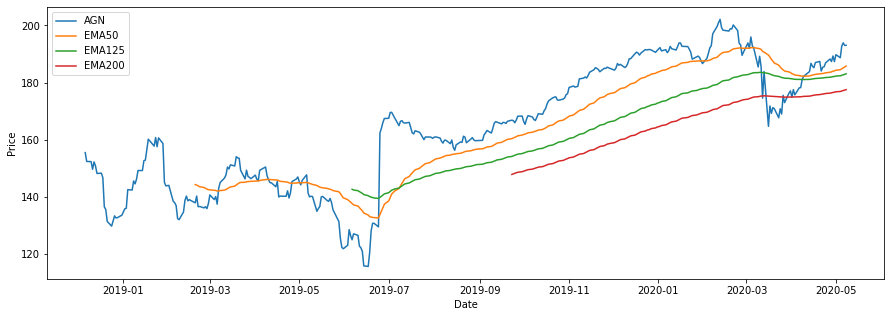

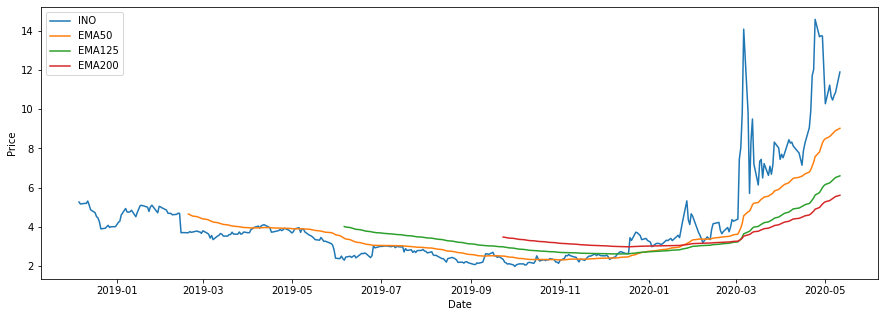

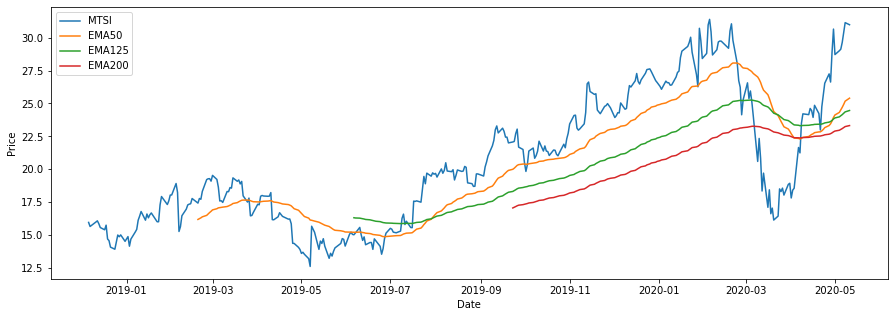

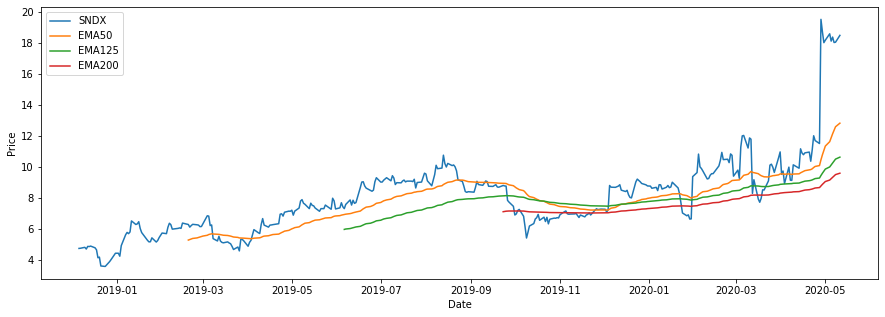

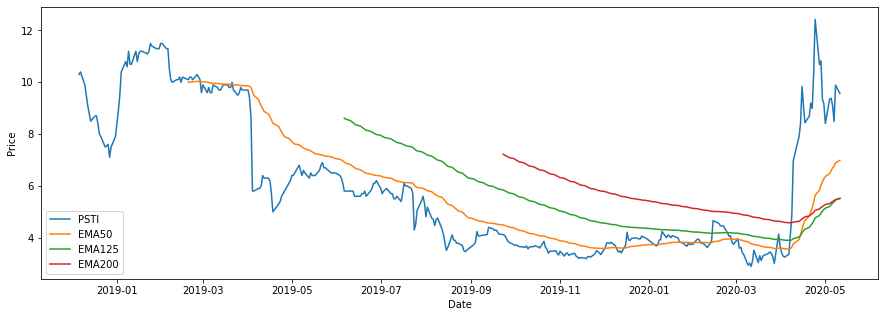

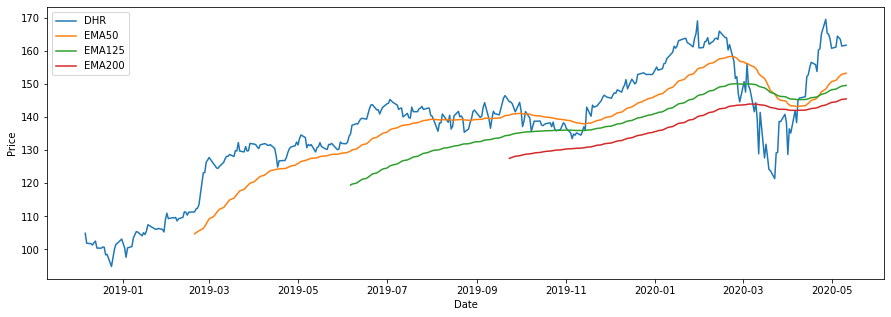

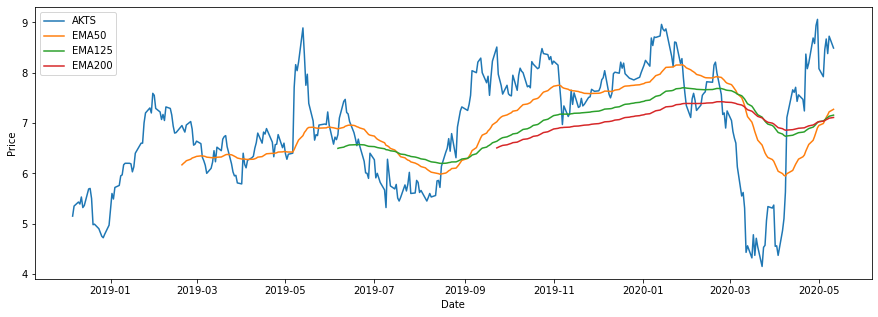

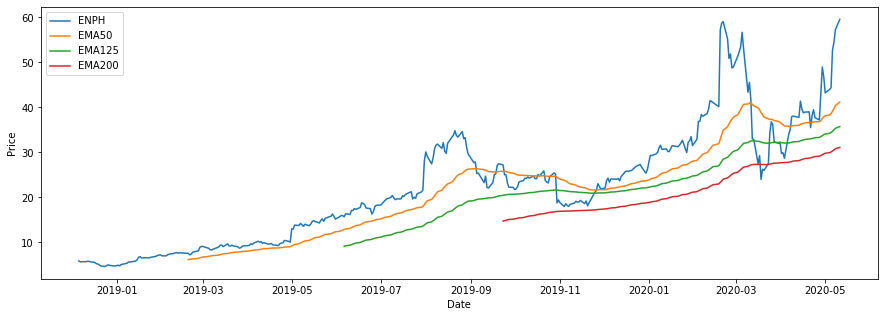

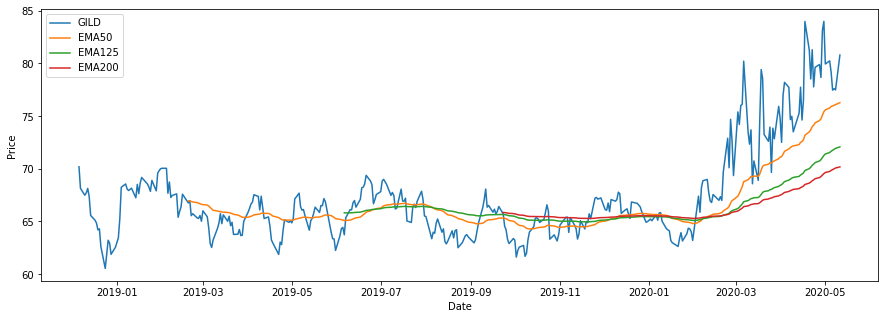

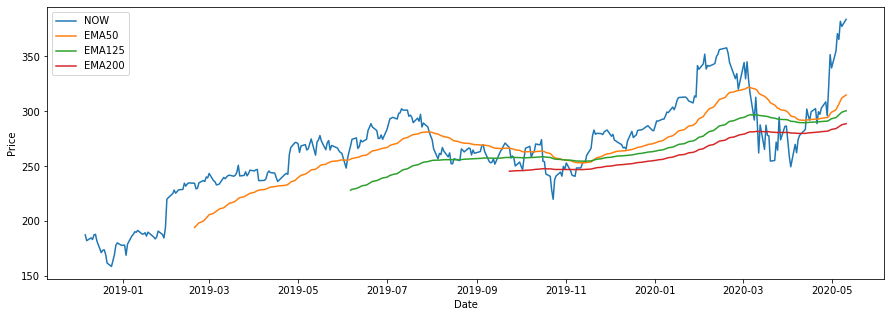

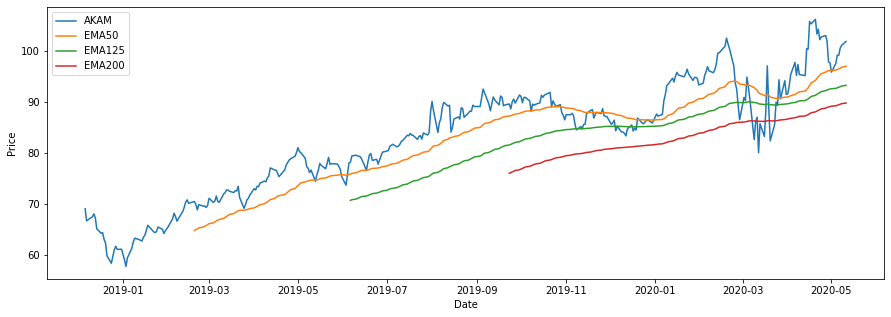

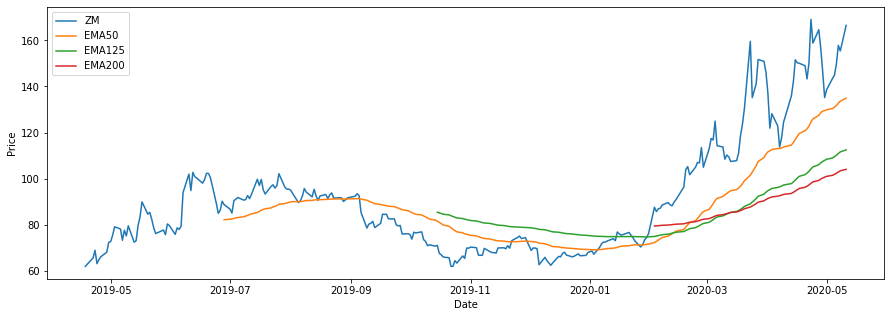

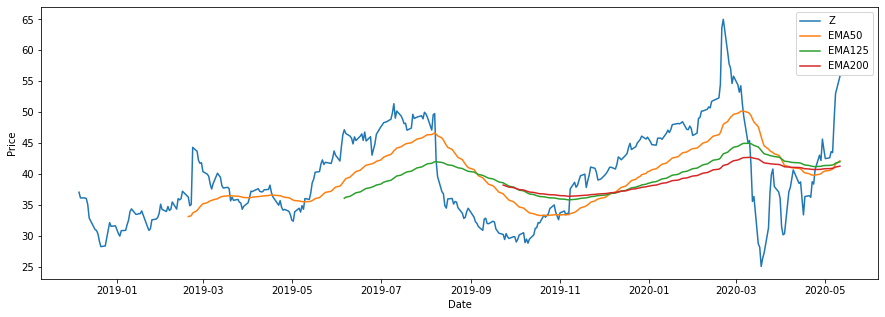

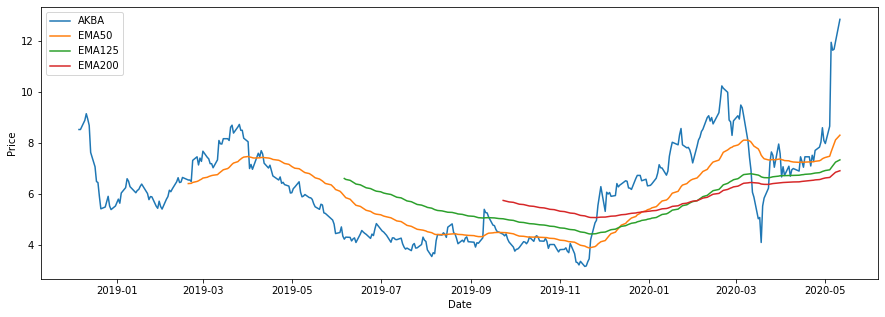

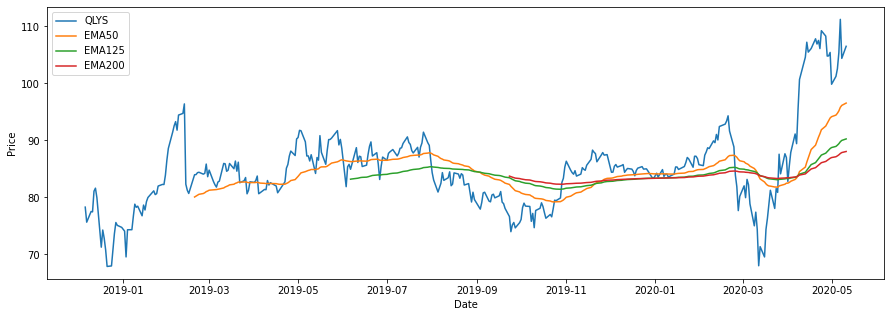

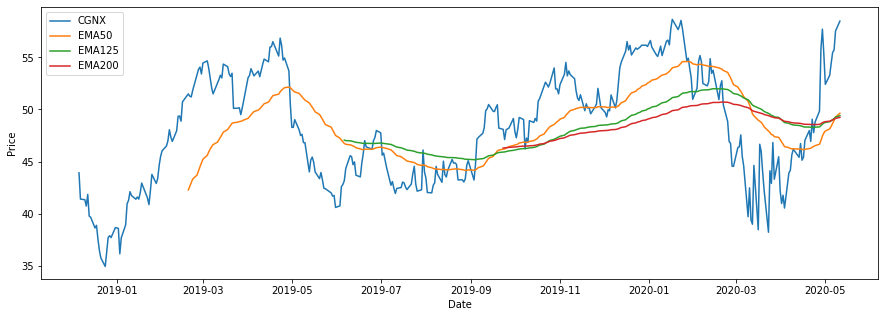

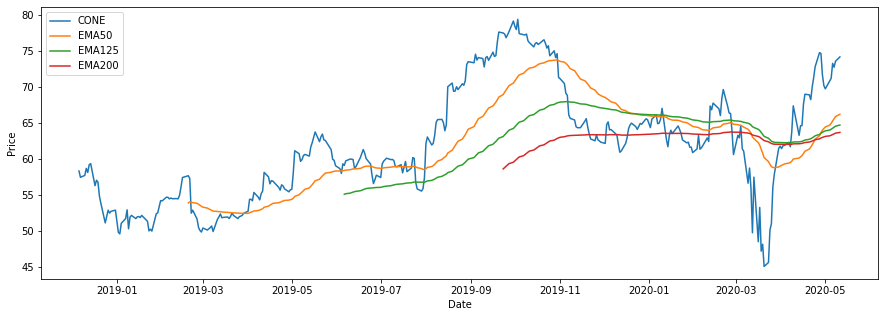

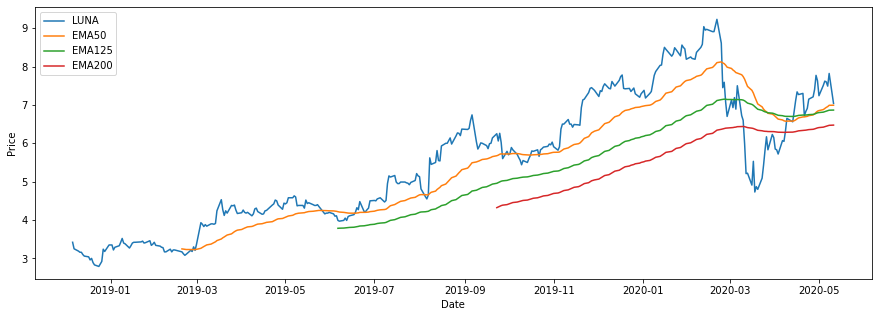

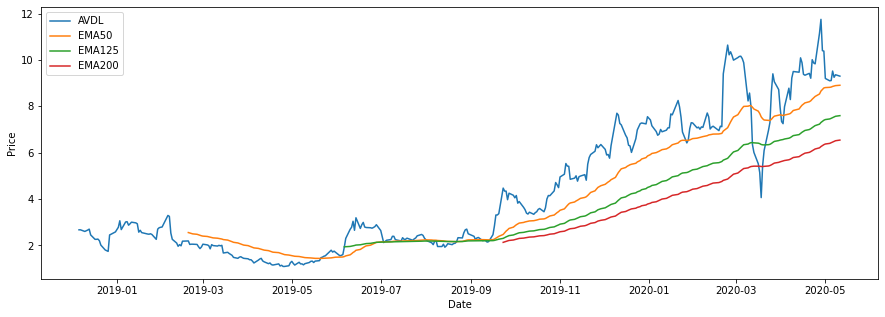

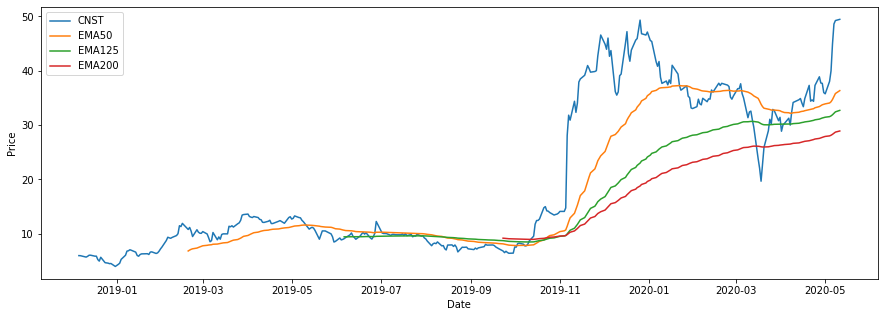

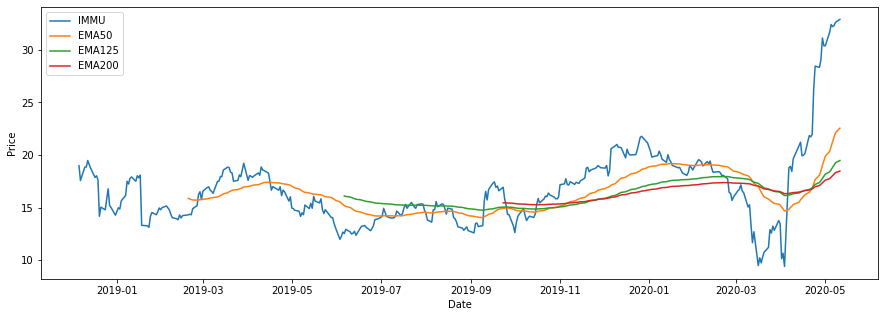

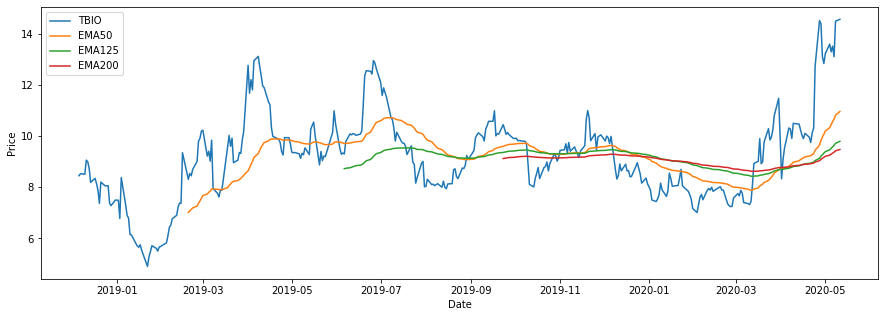

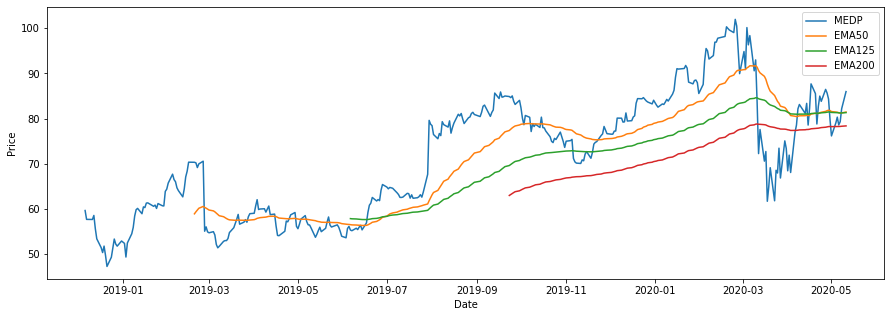

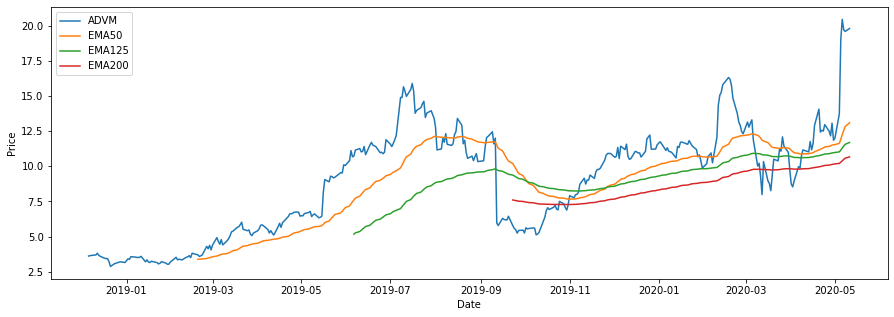

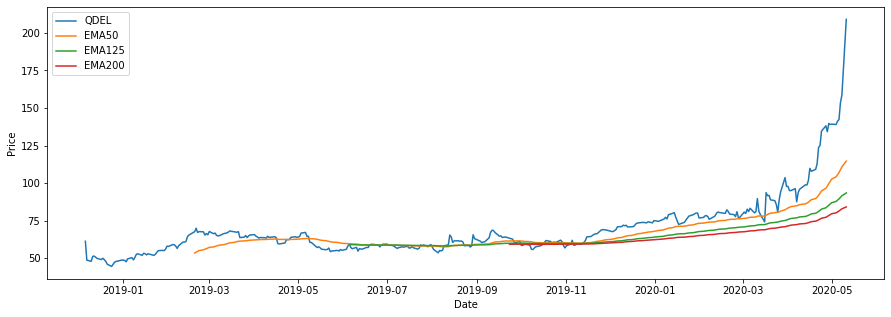

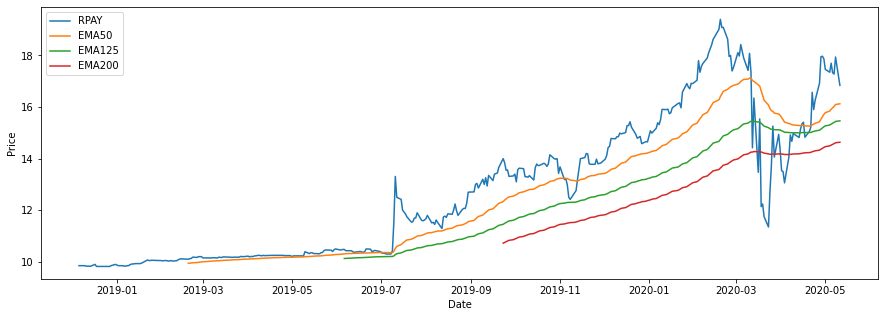

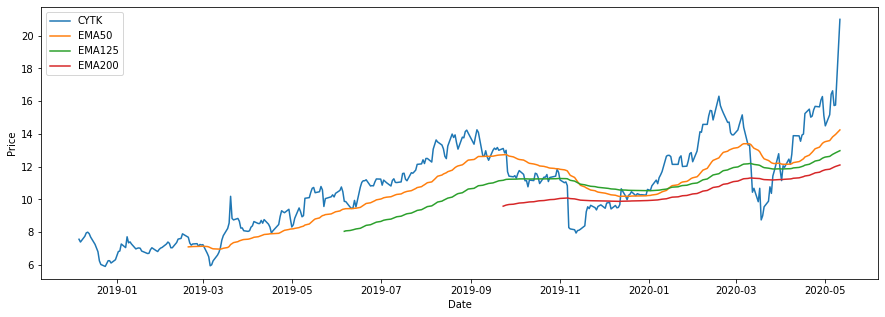

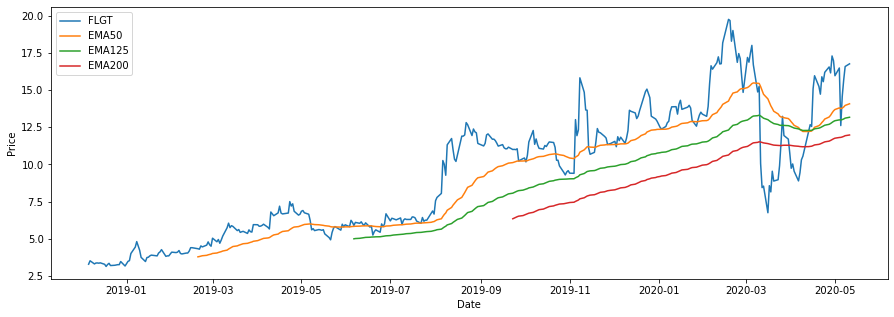

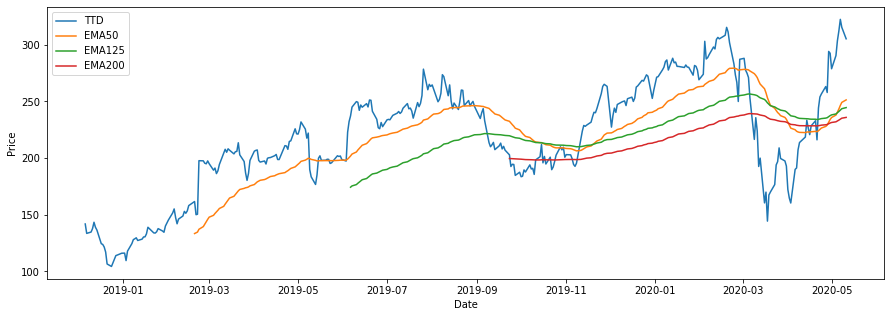

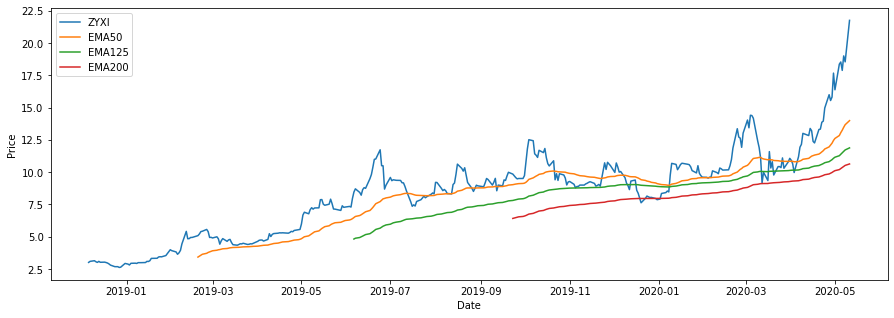

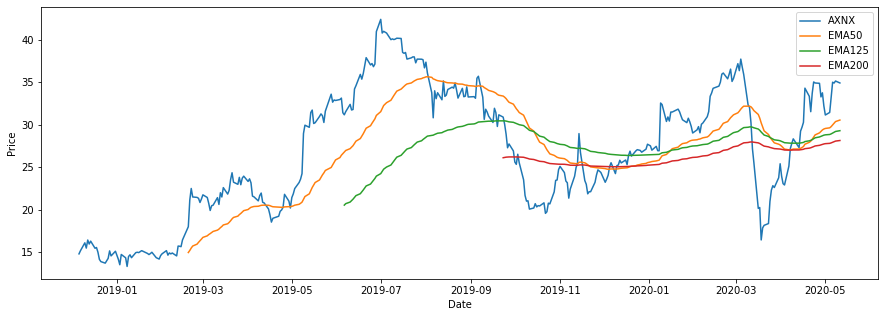

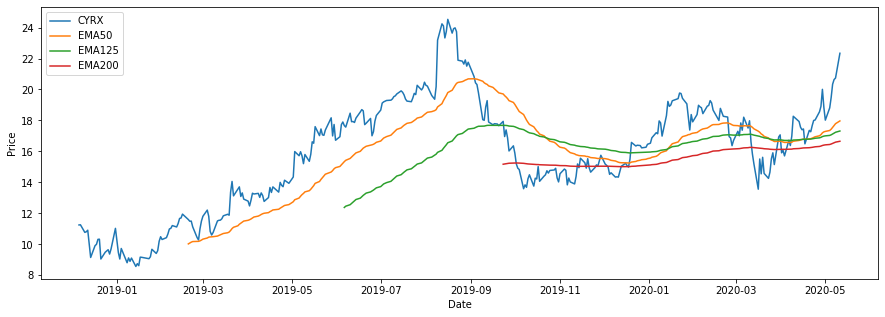

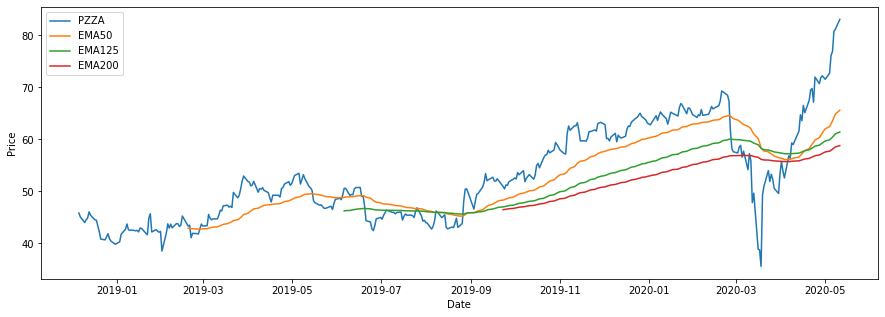

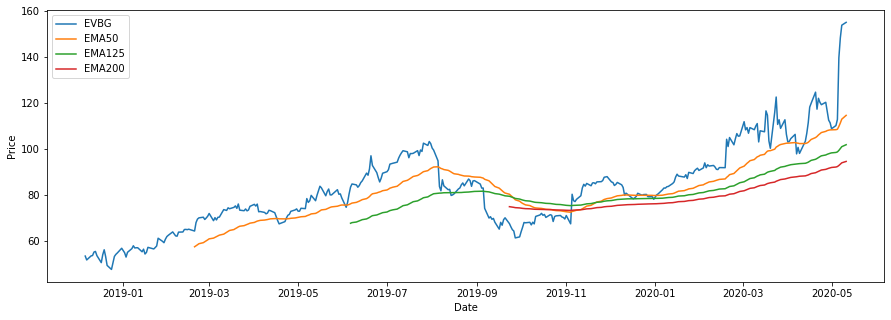

Exception: inputs are all NaN

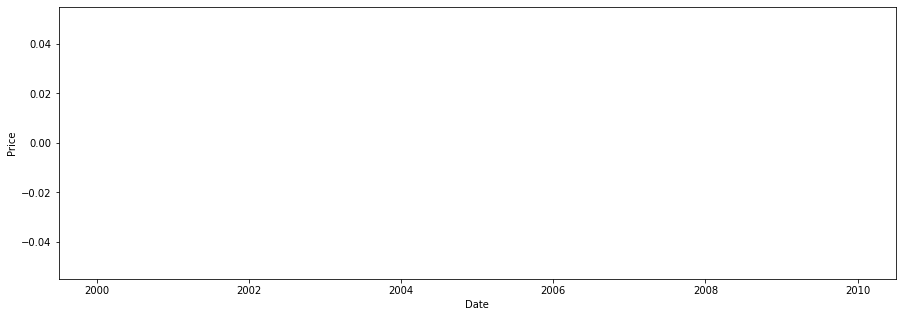

In [72]:
for s in exportList.Stock.values:
    perf = all_data[s][-360:]
    plt.figure(figsize=(15,5))
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.plot(perf.index, perf.Close, label=s)
    plt.plot(perf.index, ta.EMA(perf.Close, timeperiod=50), label='EMA50')
    plt.plot(perf.index, ta.EMA(perf.Close, timeperiod=125), label='EMA125')
    plt.plot(perf.index, ta.EMA(perf.Close, timeperiod=200), label='EMA200')    
    plt.legend()
    plt.show()